# Vessel Tracing Pipeline Demo

This notebook demonstrates the complete vessel tracing pipeline with visualizations at each step.

In [2]:
import sys
sys.path.append('..')

In [3]:
from src.VesselTracer import VesselAnalysisController
from src.VesselTracer.plotting import plot_paths, plot_paths_on_axis, plot_projections, plot_projections_on_axis

In [4]:
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Load and Display Input Data

In [5]:
## 1. Load and Display Input Data
config_path = "../config/default_vessel_config.yaml"
data_path = "../test/input/"
wt_input_path = data_path + "240207_002.czi"

In [6]:
wt_controller = VesselAnalysisController(wt_input_path, config_path);
#lets try truncate instead of remove dead frames
wt_controller.config.remove_dead_frames = False;
wt_controller.image_model.truncate(axis = 0, range_values = (0, 70));


In [8]:
print("Running analysis pipeline...")
wt_controller.run_analysis(skip_regions = True)

Running analysis pipeline...
Starting analysis pipeline...
1. Extracting ROI...
Extracting ROI...
	ROI extraction complete. Final shape: (70, 1245, 1245)
ROI extraction complete
	Normalizing image to [0,1] range...
	Original range: [0.000, 65535.000]
	Normalized range: [0.000, 1.000]
3. Detrending...
Detrending volume...
	Linear trend coefficients: [0.00124999 0.02094557]
Detrending complete
	Volume shape: (70, 1245, 1245)
	Volume shape: (70, 1245, 1245)
4. Background estimation...
Estimating background using median filter...
	Median filter size: 37 pixels
Using CPU multithreading for median filtering
	Available CPU cores: 24
	Using default number of worker threads (24)


Processing slices: 100%|██████████| 70/70 [01:15<00:00,  1.07s/slice]


Background estimation complete
	Background volume range: [0.002, 0.336]
4b. Background subtraction...
Background subtracted volume range: [-0.219, 1.328]
5. Smoothing volume...
Applying regular smoothing...
	Using regular smoothing sigma (pixels):
	  X: 1.2
	  Y: 1.2
	  Z: 1.5
Regular smoothing complete
6. Binarizing vessels...
Binarizing volume...
	triangle threshold: 0.021
Binarization complete
7. Tracing vessel paths...
Tracing vessel paths...
Path tracing complete
7b. Smoothing paths...
Smoothing 3337 vessel paths...
Path smoothing complete
Error in labeling paths by surfaces: No spline surfaces available. Run determine_regions_with_splines first.
Creating region projections...
Error in analysis pipeline: Region map not available. Run region detection first.


ValueError: Region map not available. Run region detection first.

In [ ]:
#We want to get the z profiles for each ROI
wt_zprofile = wt_controller.roi_model.get_projection([1,2], volume_type='volume')
#Get the image projections
wt_xy_proj_full = wt_controller.image_model.get_projection(0, volume_type='volume')
wt_xy_proj_roi = wt_controller.roi_model.get_projection(0, volume_type='binary', depth_coded = True)
wt_xz_proj_roi = wt_controller.roi_model.get_projection(1, volume_type='volume')

In [ ]:
wt_x_path_roi, wt_y_path_roi, wt_z_path_roi, wt_path_color = wt_controller.roi_model.get_path_coordinates()

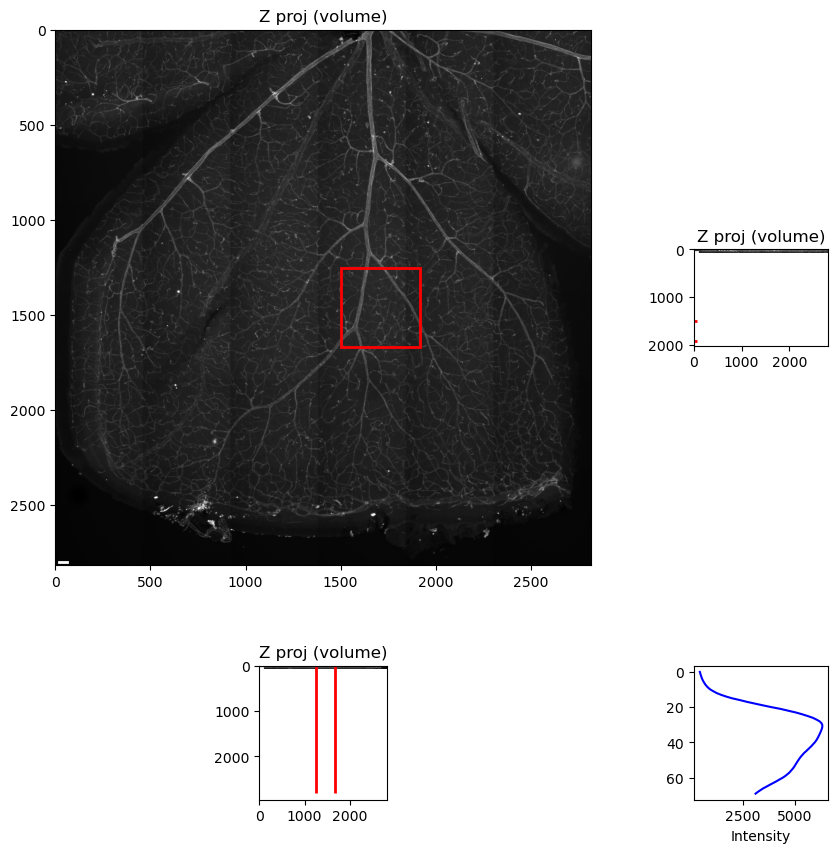

In [ ]:
fig_wt_roi = plot_projections(wt_controller, source = 'image', show_roi_box = True, mode = 'volume')

<Figure size 640x480 with 0 Axes>

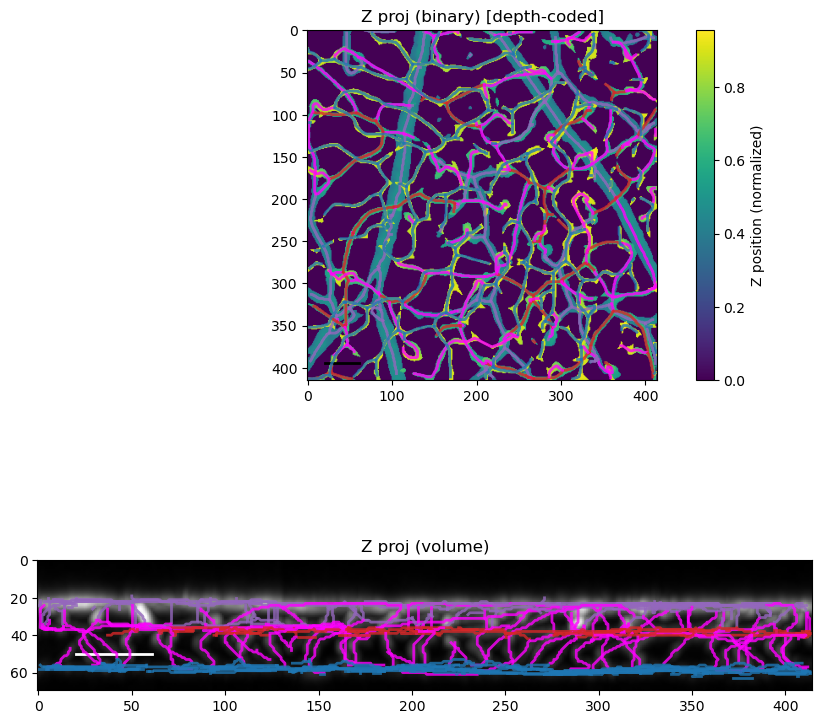

In [ ]:
fig = plt.figure()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
plot_projections_on_axis(ax1, wt_controller, projection = "z", mode = "binary", depth_coded = True)
plot_paths_on_axis(ax1, wt_controller,  projection = "xy", linewidth = 2, region_colorcode=True)

plot_projections_on_axis(ax2, wt_controller, projection = "x", mode = "volume")
plot_paths_on_axis(ax2, wt_controller,  projection = "zy", linewidth = 2, region_colorcode=True)


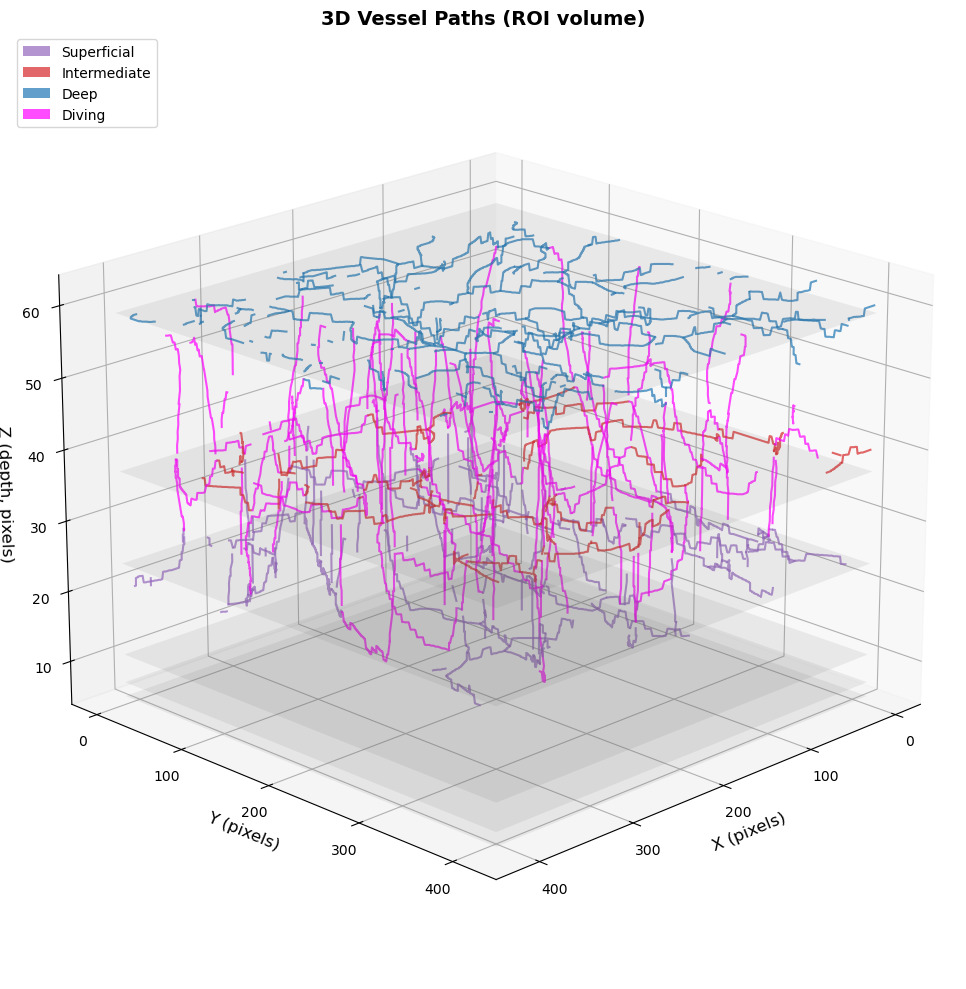

3D vessel visualization complete!
Smoothing was enabled with method: gaussian


In [ ]:
## 3D Visualization of Vessel Paths

# Import the 3D plotting function
from src.VesselTracer import plot_vessel_paths_3d

# Create 3D plot with smoothed, noodly vessel lines
# Note: Path smoothing is now handled in the analysis pipeline (step 7b)
# Smoothing parameters can be configured in the config file or controller.config
fig_3d, ax_3d = plot_vessel_paths_3d(
    wt_controller, 
    source='roi',                # Use ROI model data
    region_colorcode=True,       # Color by vascular layer
    linewidth=1.5,               # Make lines visible but not too thick
    alpha=0.7,                   # Semi-transparent lines
    elev=20,                     # Viewing angle elevation
    azim=45,                     # Viewing angle azimuth
    show_region_planes=True      # Show semi-transparent planes at region boundaries
)

plt.show()
print("3D vessel visualization complete!")
print(f"Smoothing was {'enabled' if wt_controller.config.smooth_paths else 'disabled'} with method: {wt_controller.config.smooth_method}")


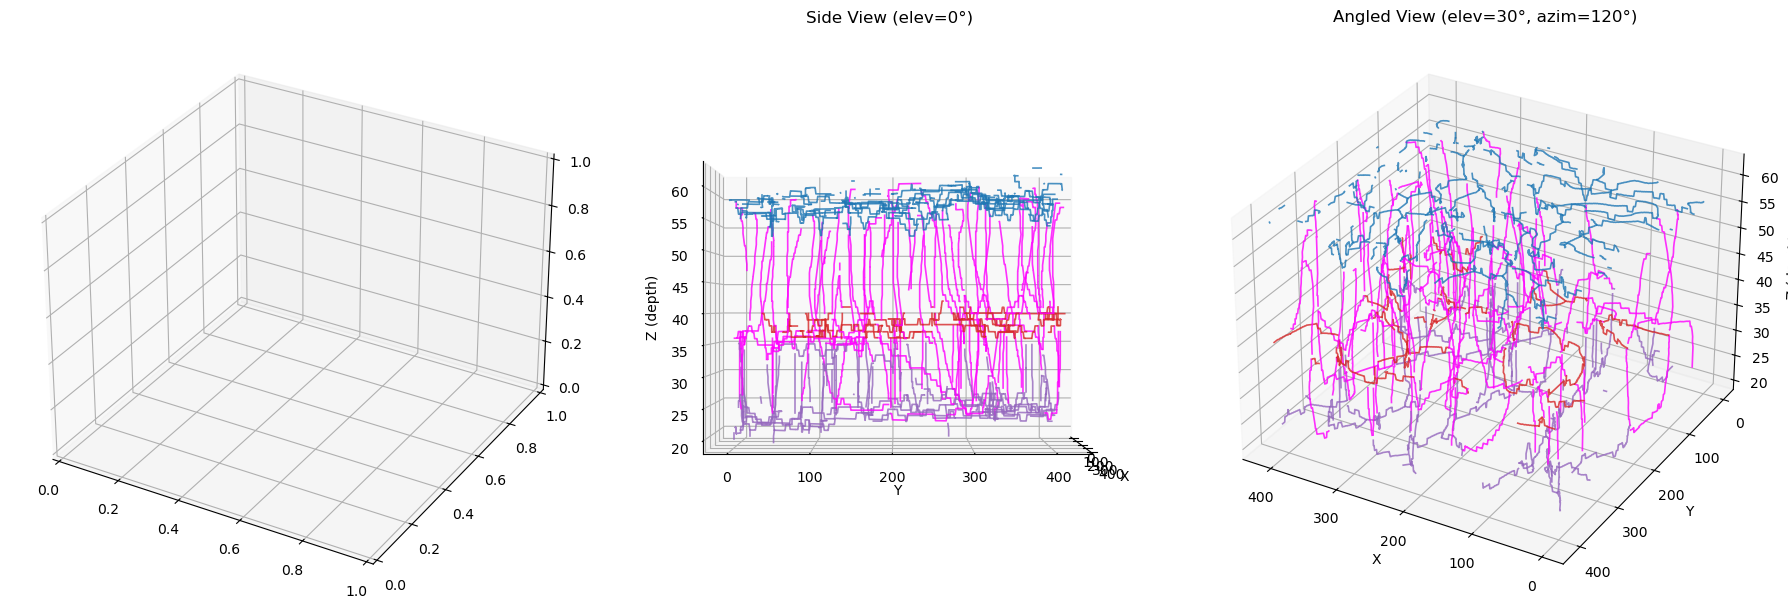

Multi-angle 3D visualization complete!


In [ ]:
## Multiple 3D Views from Different Angles

# Create a figure with 3 different viewing angles
fig = plt.figure(figsize=(18, 6))

# Top view (looking down)
ax1 = fig.add_subplot(131, projection='3d')
fig_temp, _ = plot_vessel_paths_3d(wt_controller, elev=90, azim=0, 
                                    linewidth=1.2, alpha=0.8, 
                                    show_region_planes=False)
plt.close(fig_temp)  # Close temporary figure

# Side view
ax2 = fig.add_subplot(132, projection='3d')
for x, y, z, color in zip(*wt_controller.roi_model.get_path_coordinates(
        region_colorcode=True, region_bounds=wt_controller.roi_model.region_bounds)):
    ax2.plot(x, y, z, color=color, linewidth=1.2, alpha=0.8)
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z (depth)')
ax2.set_title('Side View (elev=0°)')
ax2.view_init(elev=0, azim=0)

# Angled view
ax3 = fig.add_subplot(133, projection='3d')
for x, y, z, color in zip(*wt_controller.roi_model.get_path_coordinates(
        region_colorcode=True, region_bounds=wt_controller.roi_model.region_bounds)):
    ax3.plot(x, y, z, color=color, linewidth=1.2, alpha=0.8)
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z (depth)')
ax3.set_title('Angled View (elev=30°, azim=120°)')
ax3.view_init(elev=30, azim=120)

plt.tight_layout()
plt.show()
print("Multi-angle 3D visualization complete!")


In [ ]:
## Controlling Path Smoothing

# Path smoothing happens automatically during analysis (step 7b)
# You can control smoothing parameters through the config:

# Example: Disable smoothing
# wt_controller.config.smooth_paths = False

# Example: Use spline smoothing instead of Gaussian
# wt_controller.config.smooth_method = 'spline'
# wt_controller.config.spline_smoothing = 0.5  # Lower = less smoothing

# Example: Adjust Gaussian smoothing strength
# wt_controller.config.smooth_method = 'gaussian'
# wt_controller.config.smooth_sigma = 3.0  # Higher = more smoothing

# Current smoothing settings:
print(f"Smooth paths: {wt_controller.config.smooth_paths}")
print(f"Method: {wt_controller.config.smooth_method}")
print(f"Gaussian sigma: {wt_controller.config.smooth_sigma}")
print(f"Spline smoothing: {wt_controller.config.spline_smoothing}")
